In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
# read the sailbuoy data into a pandas dataframe and do some quality control

path = '../../data/data.txt'
data = pd.read_csv(path,sep='\t',header=None,skiprows=0)

data.columns = data.iloc(0)[0]

df = data.drop(0)

cols_to_drop = ['Count', 'TTFF', 'Commands', 'TxTries', 'ONT', 
                'DiskUsed', 'Files', 'I', 'V', 'Temperature', 'AirmarAirFix',       
                'DCPSStatus', 'DCPSOnMin']

df = df.drop(columns=cols_to_drop)

In [3]:
# convert to xarray

ds = df.to_xarray()

ds = ds.swap_dims({'index':'Time'}).drop(['index'])

ds['Time'] = pd.to_datetime(ds['Time'])

for v in ds.data_vars:

    ds[v] = ds[v].astype(float)

    if v == 'nan':
        ds = ds.drop_vars(v)

/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_60965/1712384907.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.swap_dims({'index':'Time'}).drop(['index'])


In [4]:
# cut the time series 

ds = ds.isel(Time = ds['Time']>np.datetime64('2025-03-25 10:00:00'))

In [5]:
def calculate_uv(speed, direction):
    """
    Calculate the u and v components of ocean surface velocity from speed and direction.
    
    Parameters:
    speed (float): Speed of the ocean surface velocity
    direction (float): Direction of the ocean surface velocity in degrees
    
    Returns:
    tuple: u and v components of the ocean surface velocity
    """
    # Convert direction from degrees to radians
    direction_rad = np.deg2rad(direction)
    
    # Calculate u and v components
    u = speed * np.cos(direction_rad)
    v = speed * np.sin(direction_rad)
    
    return u, v

ds['v'], ds['u'] = calculate_uv(ds['DCPSSpeed'], ds['DCPSDirection'])

In [6]:
import gsw

def convert_to_salinity(conductivity, temperature, pressure=0):
    """
    Convert conductivity and temperature to salinity using the Gibbs SeaWater (GSW) Oceanographic Toolbox.
    
    Parameters:
    conductivity (float): Conductivity in mS/cm
    temperature (float): Temperature in degrees Celsius
    pressure (float): Pressure in dbar (default is 0)
    
    Returns:
    float: Calculated salinity
    """
    # Convert conductivity from mS/cm to S/m
    conductivity_S_per_m = conductivity
    
    # Calculate salinity using GSW toolbox
    salinity = gsw.SP_from_C(conductivity_S_per_m, temperature, pressure)
    
    return salinity

ds['AADI_Sal'] = convert_to_salinity(ds.AADI_Cond, ds.AADI_Temp)

In [7]:
lon_min, lon_max = 17, 19, 
lat_min, lat_max = -35.1, -33.6

In [8]:
# read in the etopo bathymetry

bathymetry = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/etopo/ETOPO2v2c_f4.nc')  

bathymetry = bathymetry.sel(x=slice(lon_min-1, lon_max+1), y=slice(lat_min-1, lat_max+1))

bathymetry = bathymetry.where(bathymetry.z<0, np.nan)

In [9]:
# resample data to hourly 

ds_1h = ds.resample(Time='30MIN').mean()

/Users/xduplm/opt/anaconda3/envs/sb-env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'MIN' is deprecated and will be removed in a future version, please use 'min' instead.
  self.index_grouper = pd.Grouper(


In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.lines as mlines

In [20]:
def base_plot(lon_min, lon_max, lat_min, lat_max):

    # Create a plot with Cartopy
    fig = plt.figure(figsize=(7, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())    

    # Standard plotting things ------------------------------------------    

    # Plot the bathymetry data
    ax.contourf(bathymetry.x, bathymetry.y, bathymetry.z, levels=range(-3000, 100, 100), cmap=cmo.ice, transform=ccrs.PlateCarree(), extend='min')    

    # Set the extent to zoom in towards Cape Town but over the ocean
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())    

    # Add coastlines and ocean features
    ax.coastlines()
    ax.add_feature(cfeature.LAND, edgecolor='black')    

    # Add gridlines and labels
    gl = ax.gridlines(draw_labels=True, lw=0.5, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False    

    # Plot the current data 
    cs = ax.contour(bathymetry.x, bathymetry.y, bathymetry.z, levels=[-1000, -500, -200], colors='k', transform=ccrs.PlateCarree())
    ax.clabel(cs, inline=True, fontsize=8)

    quiver = ax.quiver(ds_1h.Long, ds_1h.Lat, ds_1h.u, ds_1h.v, transform=ccrs.PlateCarree(), scale=10, headlength=4, headwidth=2, width=0.003, facecolor='r', zorder=100)

    # Add a quiver key to the plot
    ax.quiverkey(quiver, X=0.1, Y=1.035, U=0.5, label='0.5 m/s', labelpos='E')    

    return fig, ax

In [14]:
plot_props = dict(s=30, transform=ccrs.PlateCarree())

<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_60965/547459348.py:11: SyntaxWarning: invalid escape sequence '\d'
  plt.title('SST ($\degree$C)')
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_60965/547459348.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


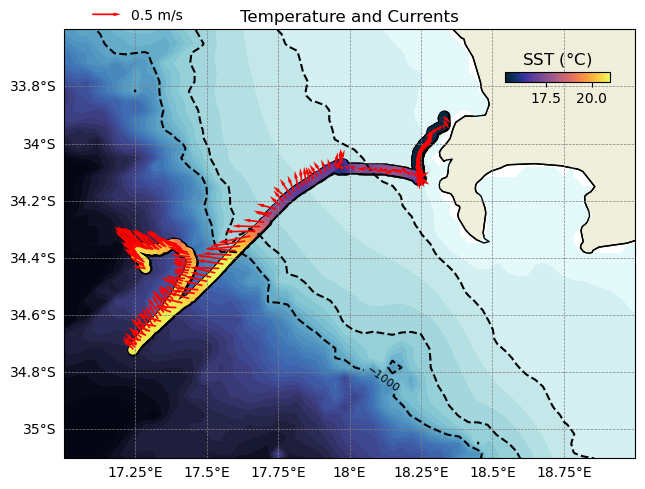

In [21]:
fig,ax = base_plot(lon_min, lon_max, lat_min, lat_max)

# Customr Plot the temperature data ------------------------------------------
img = ax.scatter(ds.Long, ds.Lat, c='k', s=60, transform=ccrs.PlateCarree())
img = ax.scatter(ds.Long, ds.Lat, c=ds.AADI_Temp, cmap=cmo.thermal, **plot_props)

ax_cb = fig.add_axes([0.75, 0.825, 0.15, 0.02])
cbar = plt.colorbar(img, cax=ax_cb, orientation='horizontal')

# Add a title
plt.title('SST ($\degree$C)')

ax.set_title('Temperature and Currents')

fig.tight_layout()

plt.savefig('../../figs/USV_Workshop_Temperature_Currents.png', dpi=300)

/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_60965/1767792479.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


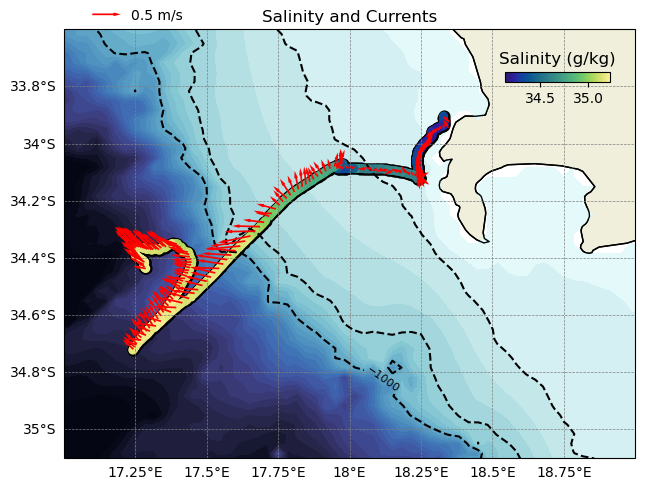

In [22]:
fig,ax = base_plot(lon_min, lon_max, lat_min, lat_max)

# Customr Plot the salinity data ------------------------------------------
img = ax.scatter(ds.Long, ds.Lat, c='k', s=60, transform=ccrs.PlateCarree())
img = ax.scatter(ds.Long, ds.Lat, c=ds.AADI_Sal, cmap=cmo.haline, **plot_props)

ax_cb = fig.add_axes([0.75, 0.825, 0.15, 0.02])
cbar = plt.colorbar(img, cax=ax_cb, orientation='horizontal')

# Add a title
plt.title('Salinity (g/kg)')

ax.set_title('Salinity and Currents')

fig.tight_layout()

plt.savefig('../../figs/USV_Workshop_Salinity_Currents.png', dpi=300)

In [23]:
import matplotlib.dates as mdates

In [24]:
ds['AirmarAirTemp'] = ds['AirmarAirTemp'].where(ds['AirmarAirTemp'] != 0, np.nan)
ds['AirmarWindSpeed'] = ds['AirmarWindSpeed'].where(ds['AirmarWindSpeed'] != 0, np.nan)
ds['AirmarWindGust'] = ds['AirmarWindGust'].where(ds['AirmarWindGust'] != 0, np.nan)

<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_60965/3316401813.py:7: SyntaxWarning: invalid escape sequence '\d'
  ax[0].set_ylabel('($\degree$C)')


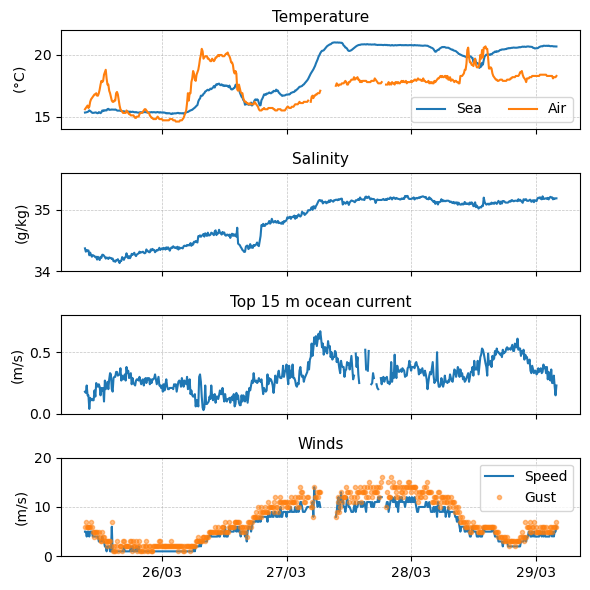

In [27]:
fig,ax=plt.subplots(4,1,figsize=(6,6), sharex=True)

# temperature
ax[0].plot(ds.Time, ds.AADI_Temp, label='Sea')
ax[0].plot(ds.Time, ds.AirmarAirTemp, label='Air')
ax[0].legend(ncol=2)
ax[0].set_ylabel('($\degree$C)')
ax[0].set_title('Temperature', fontsize=11)
ax[0].set_ylim(14, 22)

ax[1].plot(ds.Time, ds.AADI_Sal, label='Salinity')
ax[1].set_ylabel('(g/kg)')
ax[1].set_title('Salinity', fontsize=11)
ax[1].set_ylim(34, 35.6)

ax[2].plot(ds.Time, ds.DCPSSpeed, label='Speed')
ax[2].set_ylabel('(m/s)')
ax[2].set_title('Top 15 m ocean current', fontsize=11)
ax[2].set_ylim(0, 0.8)

ax[3].plot(ds.Time, ds.AirmarWindSpeed, label='Speed')
ax[3].plot(ds.Time, ds.AirmarWindGust, label='Gust', marker='.', lw=0, alpha=0.5)
ax[3].legend()
ax[3].set_ylabel('(m/s)')
ax[3].set_title('Winds', fontsize=11)
ax[3].set_ylim(0, 20)


for i in range(4):
    ax[i].grid(True, lw=0.5, ls='--', alpha=0.75)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    ax[i].xaxis.set_major_locator(mdates.HourLocator(interval=24))

fig.tight_layout()

plt.savefig('../../figs/TimeSeries.png', dpi=300)

In [ ]:
# ds['u_wind'], ds['v_wind'] = calculate_uv(ds['AirmarWindSpeed'], ds['AirmarWindDirection'])